In [1]:
from CellClass import MCImage, imread
from CellClass.Segment import Segmentation
from CellClass.process_masks import get_cell_patches
from CellClass.Preprocessing import illumination, apply_clahe
import matplotlib.pyplot as plt

DC = Segmentation("deepcell")
CP = Segmentation("cellpose")

2022-06-13 15:27:51.686893: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-13 15:27:51.686920: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-06-13 15:27:58.773132: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/cv2/../../lib64:
2022-06-13 15:27:58.773243: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot ope

uint8 0 255


/home/simon_g/anaconda3/envs/CellClass/lib/python3.9/site-packages/deepcell_toolbox/deep_watershed.py:179: FutureWarning: `selem` is a deprecated argument name for `h_maxima`. It will be removed in version 1.0. Please use `footprint` instead.
  markers = h_maxima(image=maxima,


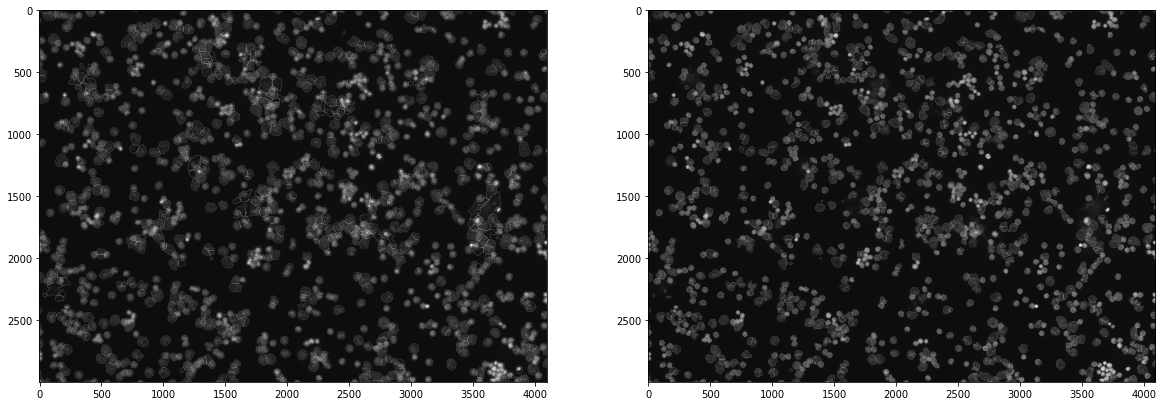

In [2]:

import numpy as np
img = imread("/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/Multimodal_Imaging_Daria/_Data_Analysis/_tmp_simon/images used by SK 20211228_Sample_cohort_with_infiltration/09-1021 Img-000423-B.TIF")
MCIm = MCImage(img, scheme="BGR")
MCIm.normalize()

MCIm.B = apply_clahe(MCIm.B)

_, res, o_dc = DC(MCIm.B, return_outline=True, image_mpp=.4, MCIm=MCIm)
_, res, o_cp = CP(MCIm.B, return_outline=True, MCIm=MCIm)

fig, ax = plt.subplots(1, 2, figsize=(20,10))
ax[0].imshow(o_dc)
ax[1].imshow(o_cp)
plt.show()

In [9]:
import os
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

base = "/data_isilon_main/isilon_images/10_MetaSystems/MetaSystemsData/MYCN_SpikeIn/patches"
files = [os.path.join(base, x) for x in os.listdir(base) if "S" in x]

In [10]:
patches = []
for f in tqdm(files):
    with open(f, "rb") as fin:
        patches.extend(pkl.load(fin))

100%|██████████| 47/47 [00:35<00:00,  1.33it/s]


In [11]:
print(len(patches))

7905


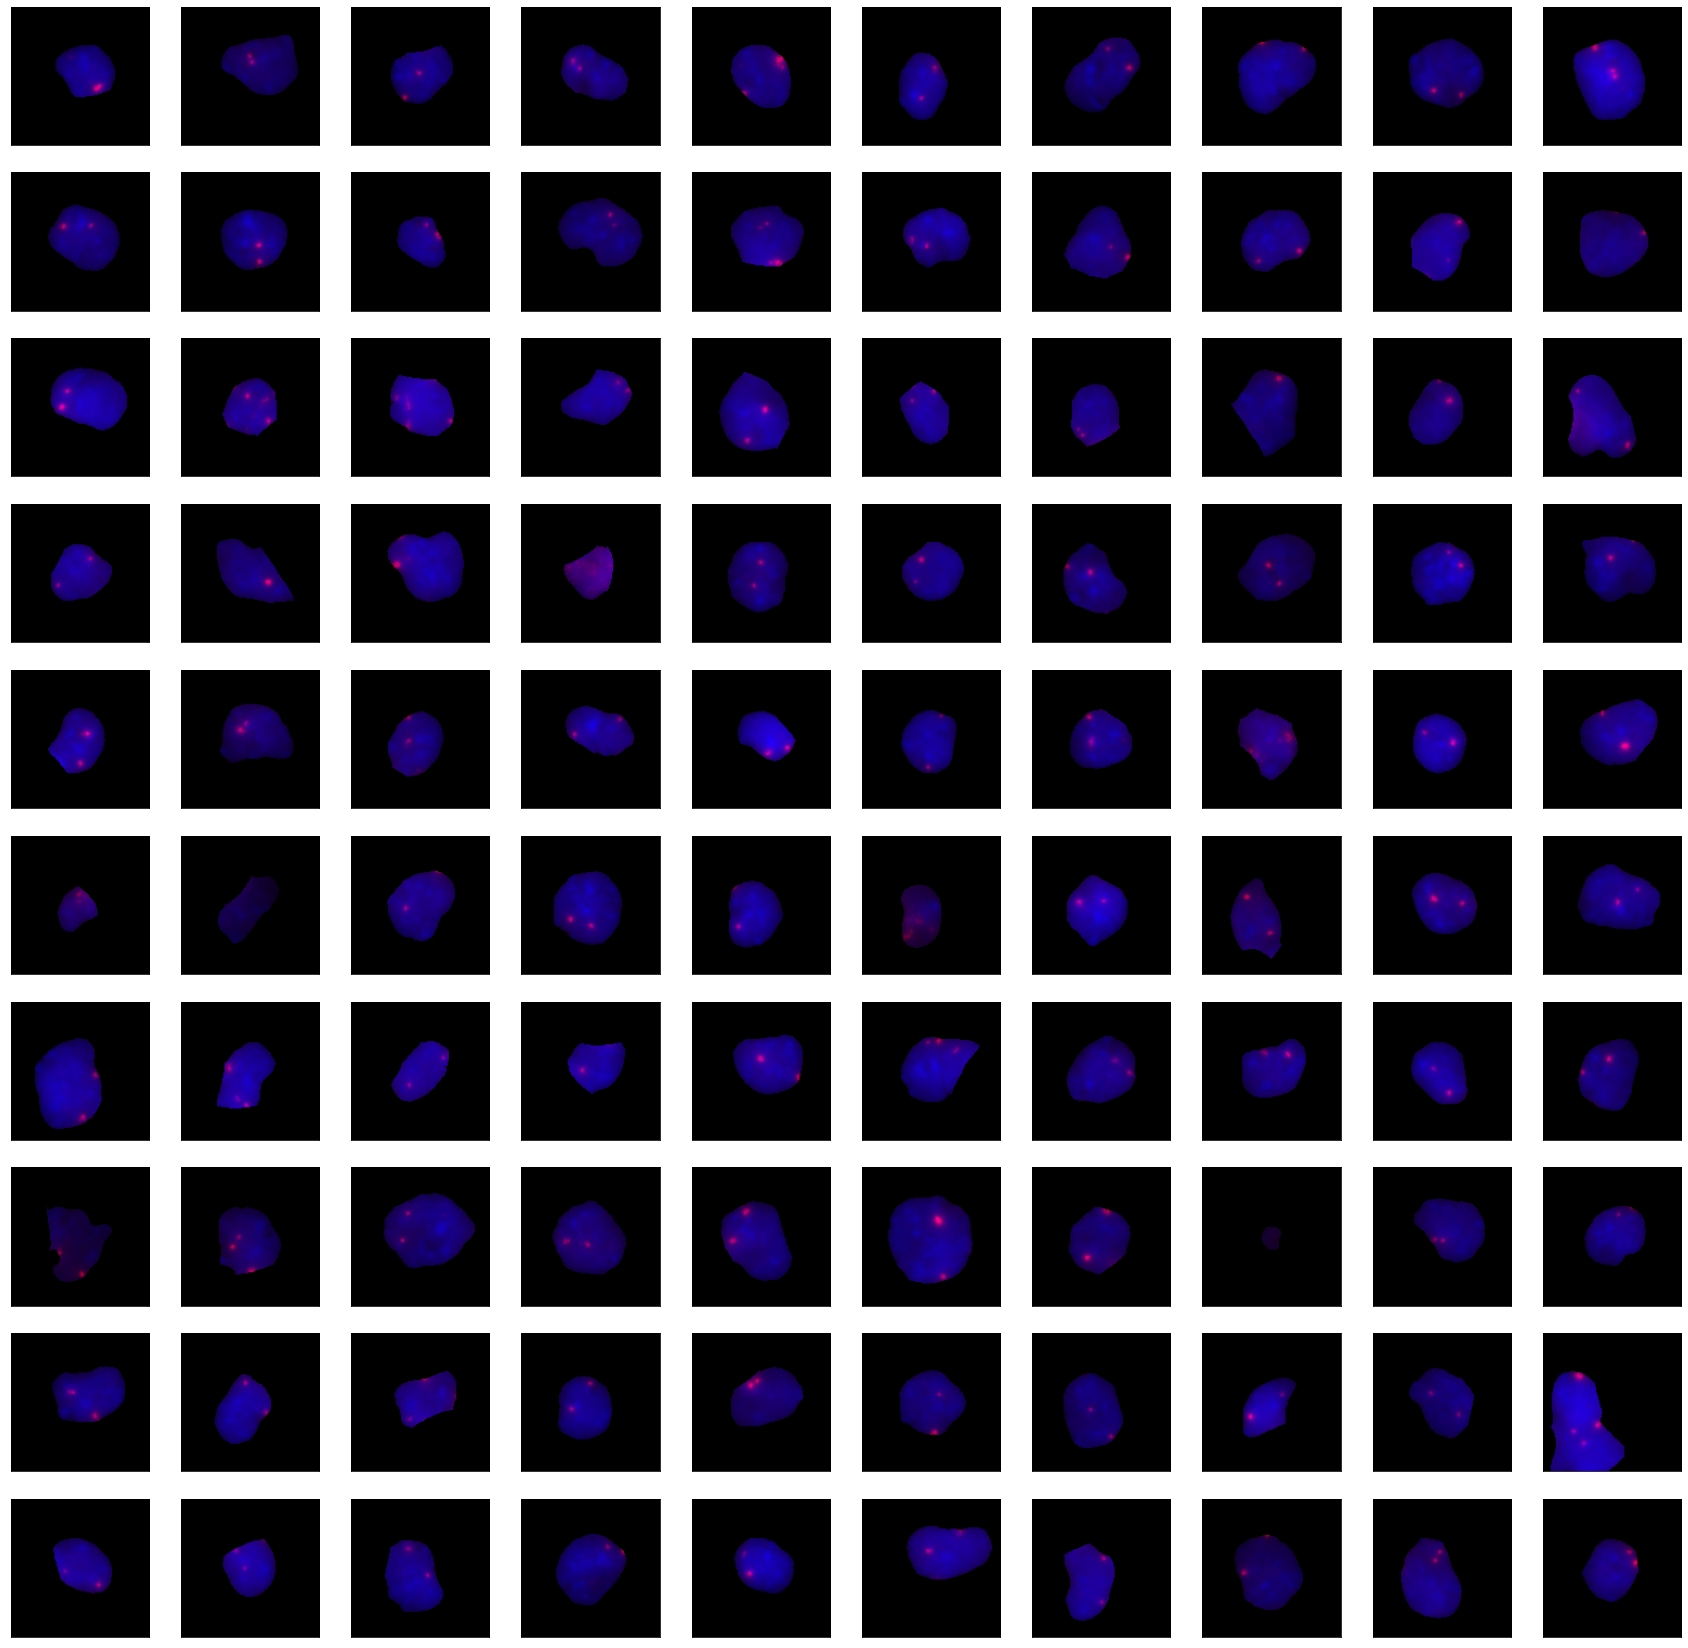

In [16]:
import numpy as np
fig, axs = plt.subplots(10, 10, figsize=(30, 30))
for ax, p in zip(axs.ravel(), patches[:100]):
    
    ax.imshow(np.stack((p.R, np.zeros_like(p.B), p.B), axis=-1))
    ax.set_xticks([])
    ax.set_yticks([])

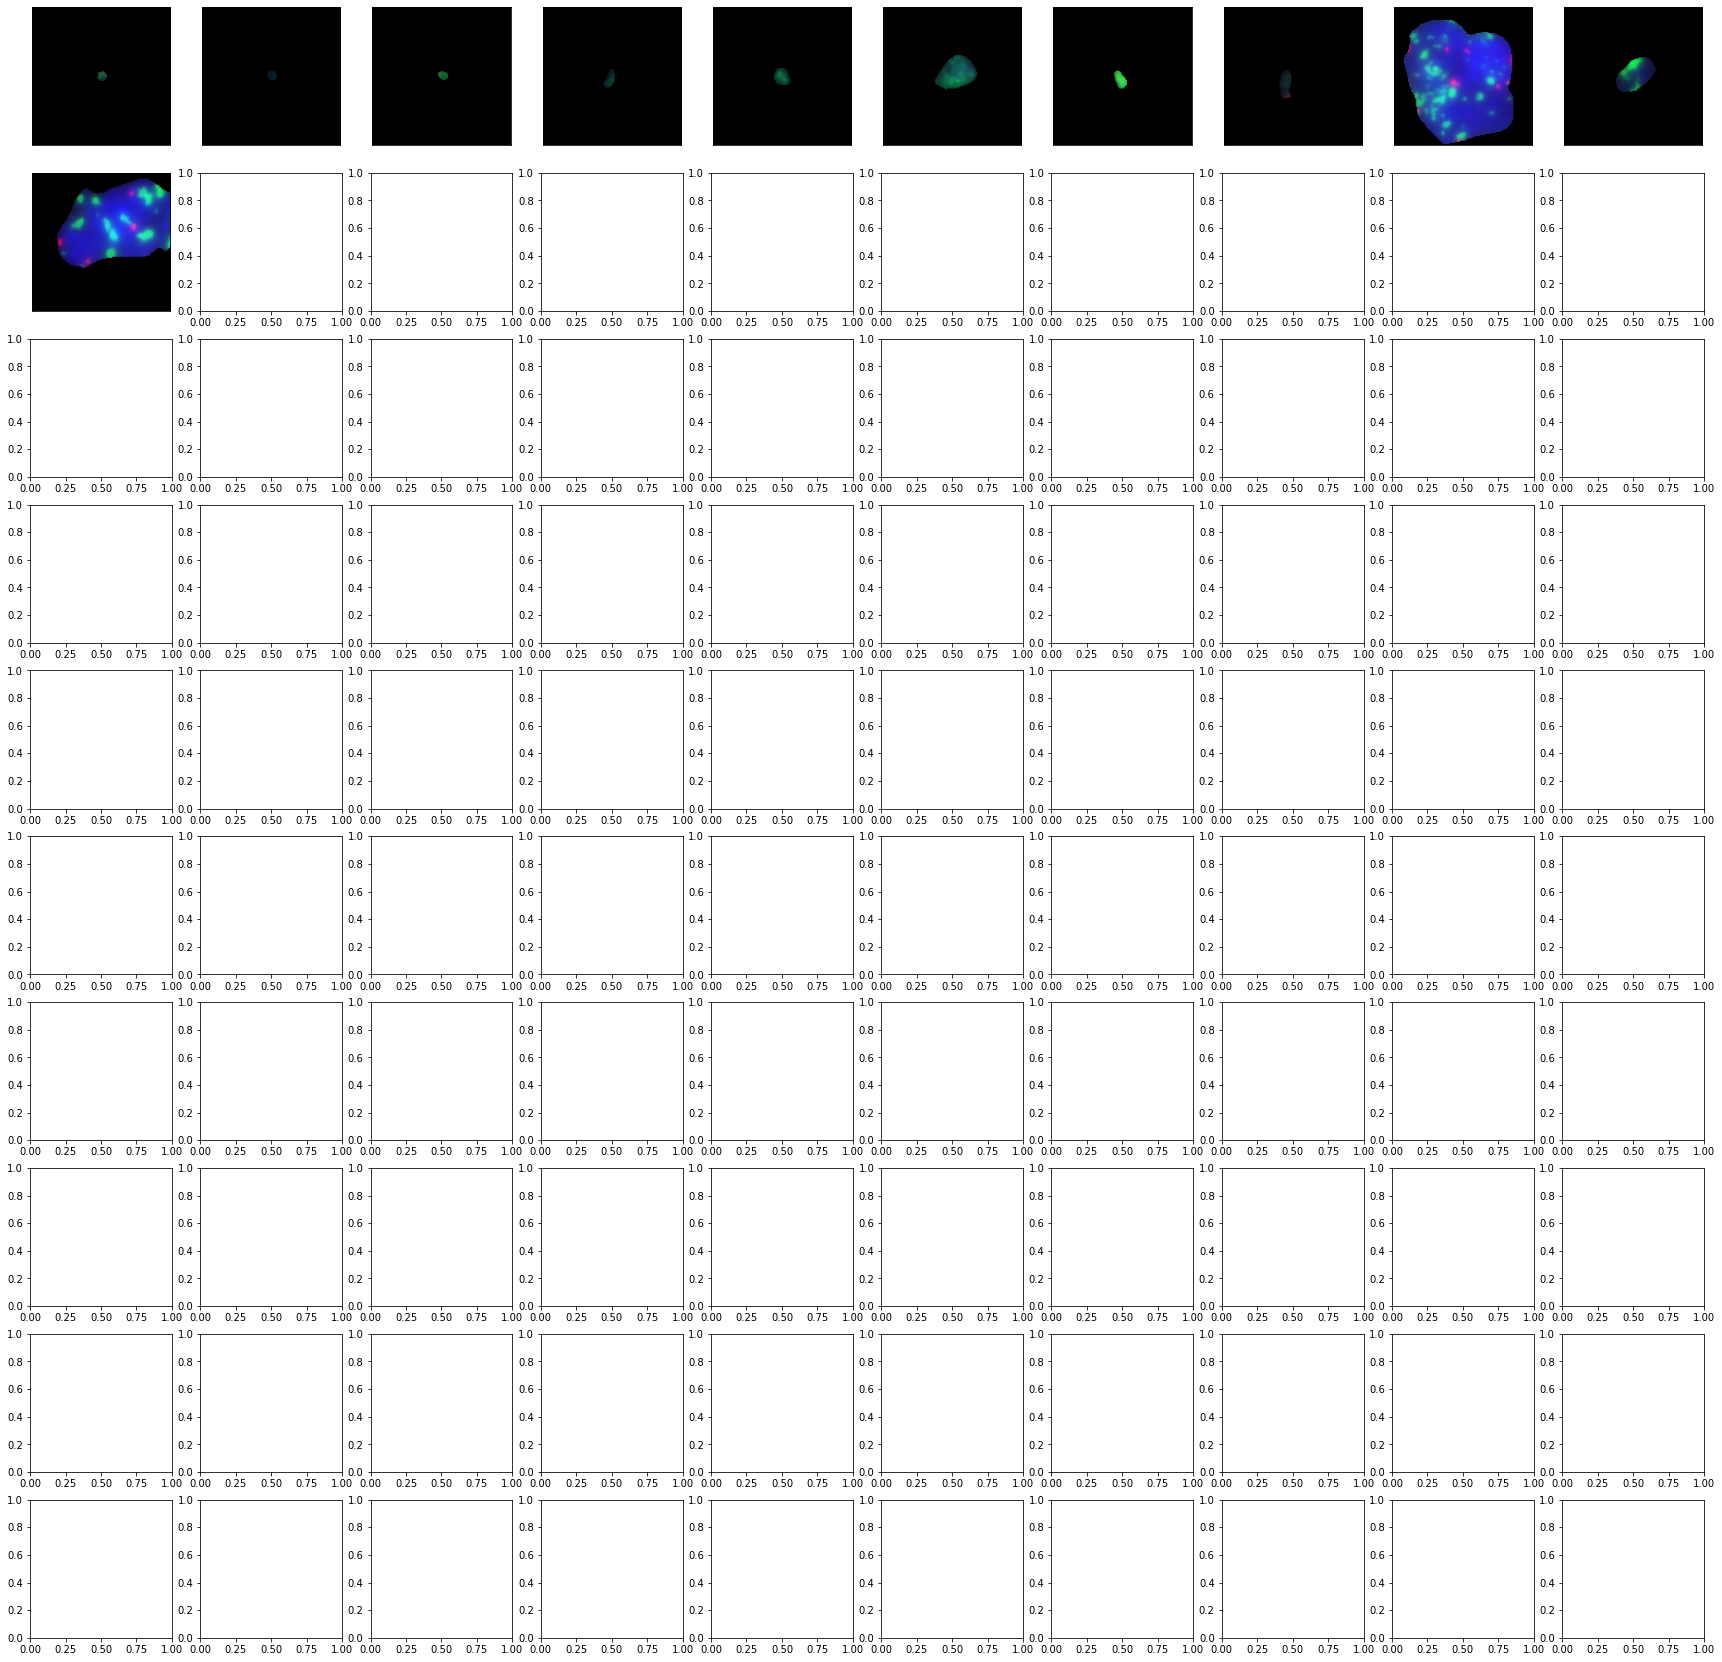

In [8]:
import matplotlib

%matplotlib inline

dat = []
ommited = []
kept = []
for p in patches[:1000]:
    
    im = p.R
    mean_B = np.mean(p.B[p.mask])
    mean_R = np.mean(p.R[p.mask])
    area = np.sum(p.mask)
    dat.append((p.RGB, mean_B, mean_R, area))
    
    if mean_B < 0.3:
        ommited.append((p.RGB, mean_B, mean_R, area))
    elif area > 6000:
        ommited.append((p.RGB, mean_B, mean_R, area))
    else:   
        kept.append((im, mean_B, mean_R, area))
        
fig, ax = plt.subplots(10, 10, figsize=(30, 30))

for i, (im) in zip(ax.ravel(), ommited):

    i.imshow(im[0])
    i.set_xticks([])
    i.set_yticks([])

In [ ]:
fig, ax = plt.subplots(10, 10, figsize=(30, 30))

for i, (im) in zip(ax.ravel(), kept):

    i.imshow(im[0])
    i.set_xticks([])
    i.set_yticks([])